Found 478 images belonging to 3 classes.
Found 118 images belonging to 3 classes.
Epoch 1/50
30/30 [==============================] - 180s 6s/step - loss: 1.1636 - accuracy: 0.5858 - val_loss: 0.8515 - val_accuracy: 0.7712 - lr: 1.0000e-04
Epoch 2/50
30/30 [==============================] - 175s 6s/step - loss: 0.7914 - accuracy: 0.8138 - val_loss: 0.7461 - val_accuracy: 0.8220 - lr: 1.0000e-04
Epoch 3/50
30/30 [==============================] - 182s 6s/step - loss: 0.6874 - accuracy: 0.8368 - val_loss: 0.6790 - val_accuracy: 0.8559 - lr: 1.0000e-04
Epoch 4/50
30/30 [==============================] - 178s 6s/step - loss: 0.5954 - accuracy: 0.8933 - val_loss: 0.6564 - val_accuracy: 0.8644 - lr: 1.0000e-04
Epoch 5/50
30/30 [==============================] - 183s 6s/step - loss: 0.5374 - accuracy: 0.9038 - val_loss: 0.6841 - val_accuracy: 0.8983 - lr: 1.0000e-04
Epoch 6/50
30/30 [==============================] - 232s 8s/step - loss: 0.5241 - accuracy: 0.9142 - val_loss: 0.5741 - val_accu

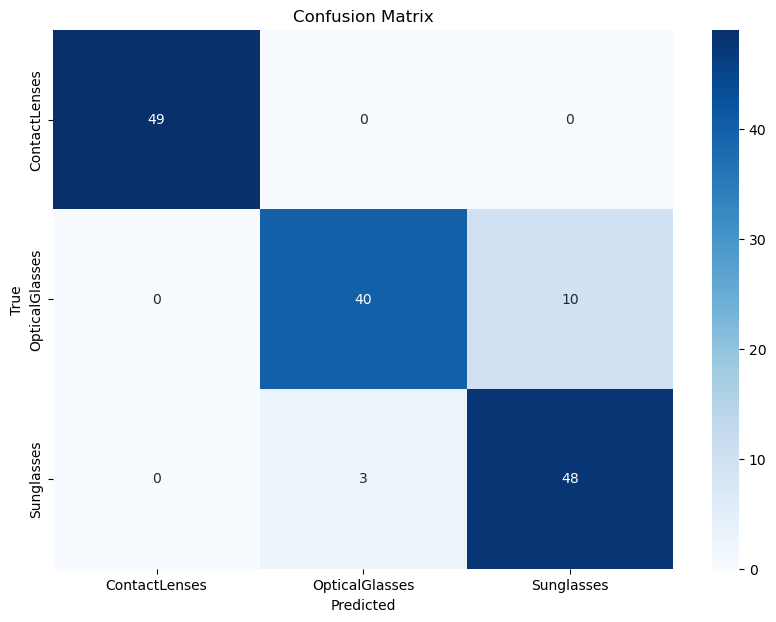

Classification Report:
                precision    recall  f1-score   support

 ContactLenses       1.00      1.00      1.00        49
OpticalGlasses       0.93      0.80      0.86        50
    Sunglasses       0.83      0.94      0.88        51

      accuracy                           0.91       150
     macro avg       0.92      0.91      0.91       150
  weighted avg       0.92      0.91      0.91       150



In [3]:
import os
import shutil
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define paths
DATASET_PATH = r'C:\New folder\Hope AI\Deep Learning\Lux\Dataset\Dataset'
TRAIN_PATH = r'C:\New folder\Hope AI\Deep Learning\Lux\Dataset\Train123'
TEST_PATH = r'C:\New folder\Hope AI\Deep Learning\Lux\Dataset\Test123'

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
NUM_CLASSES = 3
SPLIT_RATIO = 0.2

# Create directories for training and testing data
for folder in ['ContactLenses','OpticalGlasses','Sunglasses']:
    os.makedirs(os.path.join(TRAIN_PATH, folder), exist_ok=True)
    os.makedirs(os.path.join(TEST_PATH, folder), exist_ok=True)

def clean_filename(filename):
    # Replace invalid characters with underscores
    return re.sub(r'[<>:"/\\|?*]', '_', filename)

def split_data(class_folder):
    class_folder_path = os.path.join(DATASET_PATH, class_folder)
    images = [os.path.join(class_folder_path, img) for img in os.listdir(class_folder_path) if os.path.isfile(os.path.join(class_folder_path, img))]
    
    if not images:
        print(f"No images found in {class_folder_path}")
        return

    # Rename files if necessary
    renamed_images = []
    for img in images:
        dir_name, filename = os.path.split(img)
        cleaned_filename = clean_filename(filename)
        new_path = os.path.join(dir_name, cleaned_filename)
        if img != new_path:
            os.rename(img, new_path)
        renamed_images.append(new_path)

    # Split data
    train_imgs, test_imgs = train_test_split(renamed_images, test_size=SPLIT_RATIO, random_state=42)
    
    for img in train_imgs:
        try:
            shutil.copy(img, os.path.join(TRAIN_PATH, class_folder))
        except Exception as e:
            print(f"Error copying {img}: {e}")

    for img in test_imgs:
        try:
            shutil.copy(img, os.path.join(TEST_PATH, class_folder))
        except Exception as e:
            print(f"Error copying {img}: {e}")

# Perform the split for each class
for folder in ['ContactLenses','OpticalGlasses','Sunglasses']:
    split_data(folder)

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Transfer Learning with VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 15

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save the final model
model.save('final_eyewear_classifier_model88.h5')

# Load the best model for evaluation
model = load_model('best_model.h5')

# Evaluate the model on the test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / BATCH_SIZE))
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Define constants
IMAGE_SIZE = (224, 224)  # Ensure this matches the input size expected by your model
MODEL_PATH = 'final_eyewear_classifier_model88.h5'  # Path to your trained model

# Load the trained model
model = load_model(MODEL_PATH)

# Function to preprocess the image and make predictions
def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1]

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Map class indices to class labels
    class_labels = ['ContactLenses','OpticalGlasses','Sunglasses']  # Update these if different
    predicted_label = class_labels[predicted_class]
    
    # Display image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

    return predicted_label


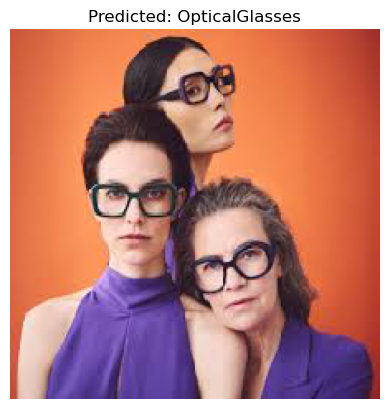

The image is classified as: OpticalGlasses


In [10]:
# Example usage
img_path = r'C:\Users\AB92922\Downloads\11.jpeg'  # Update with the path to your image
predicted_label = predict_image(img_path)
print(f'The image is classified as: {predicted_label}')